## Interactive Ideal Gas Law Optimization

In this notebook, we will demonstrate how to use LINQX infrastructure components to perform an interactive optimization of the ideal gas law (PV=nRT). There are three main learning objective from this notebook

1. How to define interactive LINQX commands which allow for users to control what **parameters are input** at runtime via the command line -- `class InteractiveParameterDriverCommand`
2. How to define interactive LINQX commands which allow for users to control what **results are output** at runtime via the command line -- `class InteractiveResultDriverCommand`
3. How to use the EvoTorch optimization package to optimize interactive LINQX workflows

The main use case of interactive LINQX commands is when there is a chemically relevant workflow which needs optimization that cannot interface with python (i.e. old computer connected to instrumentation).

For this notebook, lets pretend that we have a machine which allows for you to control an ideal gas systems `temperature` and `volume` and has a sensor which can measure the systems `pressure`. 

For the first part of the notebook, we will assume that the machine **CAN** interface with python code. You will be build a command which can interface with the machine and modify the `temperature` and `volume` of the system based on command line user input. The command will return the `pressure` read by the sensor.

For the second part of the notebook, we will assume that the machine **CANNOT** interface with python code. Our goal is to **MAXIMIZE** the `pressure` of the system by having the EvoTorch optimization algorithm tell use what `temperature` and `volume` to set the system to. You will build a command which prints out `temperature` and `pressure` values provided by the optimization algorithm and provides `pressure` values input by the user back to the optimization algorithm.

### Imports

In [84]:
%matplotlib inline
import sys
sys.path.append("../JSON/")

# LINQX imports
from models.parameter.base import ParameterModel
from models.command.core import (
    InteractiveParameterDriverCommand, 
    InteractiveResultDriverCommand
)
from models.workflow.base import BaseDriverWorkflow
from models.optimizer.base import BaseObjectiveFunction

# EvoTorch imports
from evotorch import Problem
from evotorch.algorithms import SteadyStateGA
from evotorch.operators import GaussianMutation

# Plotting imports
import matplotlib.pyplot as plt

### Define the Parameters

Prior to implementing any novel commands or workflows, parameters can be defined in a manner which restrict data types and values. Lets pretend that the `temperature` of the system can range between 200K and 400K and the `volume` of the system can range between 10L and 100L. After defining these `ParameterModels`, we can use the `to_param()` method to build `Parameter` subclasses which correspond to the defined parameters

In [85]:
# Define our parameter Models
volume_mode = ParameterModel(
    name="Volume",
    data_type="float",  # Volume data type will be a float
    upper_limit=100.0,  # Upper limit of volume is 100 L
    lower_limit=10.0,   # Lower limit of volume is 10 L
    default=50.0        # Default value will be 50 L
)
temperature_model = ParameterModel(
    name="Temperature",
    data_type="float",  # Temperature data type will be a float
    upper_limit=400.0,  # Upper limit of temperature is 400 K
    lower_limit=200.0,  # Lower limit of temperature is 200 K
    default=300.0       # Default value will be 300 K
)

# Define our parameter objects
Volume = volume_mode.to_param()
Temperature = temperature_model.to_param()

# Define our parameters
vol = Volume()
temp = Temperature()

### Define the Function

Now we need to define a function which:

1. Interfaces with our machine
2. Modifies the temperature and volume of the system
3. Reads the pressure from the sensor
4. Returns the pressure

 Since our machine is imaginary the function will assume the pressure behaves according to the idea gas law (PV=nRT)

In [86]:
# Define our function for modifying the idea gas system
def ideal_gas_law(t: float, v: float) -> float:
    # Our function will take in t (temperature) and v (volume) as input

    # Add code to modify the systems temperature to t and volume to v
    # Add code to read the pressure sensor in the system
    
    # Return a dictionary with the pressure sensors value
    return {
        "pressure": ((6.022e23)*(1.381e-23)*t)/v # PV = NkBT for 1 mol -> PV = RT
    }

# Run the function to test
ideal_gas_law(300, 50.0)

{'pressure': 49.898292}

### Build the Interactive Parameter Command

Now we define an `InteractiveParameterDriverCommand` which corresponds to calling this function. Note that at this point, neither temperature or volume are set to be interactive, so the command will be run with their default values : 
- `Temperature: 300K`
- `Volume': 50L`

In [87]:
# Define our interactive command
interactive_gas_law = InteractiveParameterDriverCommand(
    name="Idea Gas Law",
    parameters={
        "t": temp,                  # The defined temperature parameter (default=300)
        "v": vol                    # The defined volume parameter (default=50)
    },
    uuid="imaginary_machine_01",    # Our imaginary machines UUID
    fn=ideal_gas_law,               # Our idea gas law function
    has_return=True                 # It returns the pressure
)

# NOTE that at this point it will not ask for user input because none of the
# parameters are set to be interactive

# Run the function to test (defaults={"t": 300, "v": 50})
interactive_gas_law()

{'pressure': 49.898292}

### Make the Parameter Interactive

We want the `temperature` and `volume` to be interactively defined by the user. We set the `include` attribute of the `InteractiveParameterDriverCommand` to a `list` containing `['t', 'v']`.

Now when we run the command again, it will prompt the user to input values for `temperature` and `volume`.

In [88]:
# Make temperature and pressure interactive
interactive_gas_law.include = ["t", "v"]

# Run the function to test
interactive_gas_law()

{'pressure': 49.898292}

Now we have built a command which can be run in a workflow to request that a user provide some input on parameters at runtime!

### Build the Interactive Result Command

Now we will build a interactive command, but instead of it allowing the user to provide information on parameters at runtime, the user will provide information on the results at runtime.

We are now pretending that the machine **CANNOT** interface via python. Thus the user will take the values provided by the optimizer (`temperature` and `volume`) and run those on the machine, and provide the `pressure` value read from the sensor back to the optimizer. 

First we build an `InteractiveResultDriverCommand` which will print out `temperature` and `volume` varaibles and the read in `pressure` from the user.

In [90]:
# Make an interactive function which takes in the result (Pressure)
interactive_gas_law = InteractiveResultDriverCommand(
    name="Idea Gas Law",
    parameters={
        "t": temp,                  # Temperature parameter built previously
        "v": vol                    # Volume parameter built previously
    },
    uuid="imaginary_machine_01",    # Our imaginary machines UUID    
    fn=ideal_gas_law,               # Our idea gas law function (which will be run as a helper function)
    result_vars=["p"]               # We want the result of the user input to be returned as a dictionary with the key 'p'
)

# Run the function to test
interactive_gas_law()

Run Parameters: {'t': 300.0, 'v': 50.0}
Helper Function {'pressure': 49.898292}


{'p': 49.9}

### Build the Interactive Workflow

After building our interactive command, we now need to build a `BaseDriverWorkflow` which will run the command. 

We want to save off the value of the `p` key (`pressure`) to the value of the `pressure` key of the workflow global varaibles. This will be used in the objective function as the objective value to maximize.

In [91]:
# Make a workflow of this function
interactive_workflow = BaseDriverWorkflow(
    name="Interactive Gas Law Workflow",
    commands=[interactive_gas_law]      # A list of all the commands in the workflow
)

# We want to save off the pressure output 'p' to the workflow global 'pressure'
list_save_vars = [{"p": "pressure"}]

# Run this workflow to test and print the workflow globals
interactive_workflow.exec(list_save_vars=list_save_vars)
interactive_workflow.wf_globals

Run Parameters: {'t': 300.0, 'v': 50.0}
Helper Function {'pressure': 49.898292}


{'pressure': 49.9}

### Build the Objective Function based on the Workflow

We need our workflow to interface with the EvoTorch optimizer and thus we need to make an objective function which will run our interactive command to maximize the pressure.

In [97]:
# Make the function compatible for optimization (objective function)
obj_fn = BaseObjectiveFunction(
    name="Interactive Optimize Idea Gas Law",
    workflow=interactive_workflow,              # Our interactive workflow which we build
    order_kwargs=[{"t":(0,1), "v":(1,2)}],      # The first position of the input Tensor is the temperature, the second is the volume
    list_save_vars=list_save_vars,              # We want to save off the pressure to the workflow global
    fitness_criteria=["pressure"]               # We want to assess the function on the saved workflow global 'pressure'
)

# Define an EvoTorch optimization problem
problem = Problem(
    objective_sense="max",                  # We want to maximize the pressure
    objective_func=obj_fn,                  # We provided the objective function we define
    bounds=[(200.0, 10.0), (400.0, 100.0)], # We define the bounds based on the bounds of the parameters (lower, upper)
    solution_length=2                       # We expecte a solution length of 2 (temperature, pressure)
)

# Define a optimization algorithm searcher based on the problem
# Steady state genetic algorithm using guassian mutation
searcher = SteadyStateGA(problem=problem, popsize=1)
searcher.use(GaussianMutation(problem=problem, stdev=10))

[2023-07-18 15:29:14] INFO     <61548> evotorch.core: Instance of `Problem` (id:47156430566880) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-07-18 15:29:14] INFO     <61548> evotorch.core: Instance of `Problem` (id:47156430566880) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-07-18 15:29:14] INFO     <61548> evotorch.core: Instance of `Problem` (id:47156430566880) -- The `device` of the problem is set as cpu
[2023-07-18 15:29:14] INFO     <61548> evotorch.core: Instance of `Problem` (id:47156430566880) -- The number of actors that will be allocated for parallelized evaluation is 0


### Run the EvoTorch Optimizer

We will run the optimizer for 5 iterations of 3 steps each. We save off the best `pressure` and corresponding `temperature` and `volume` after each iteration. 

The helper function will be printed out for the users benefit. Pretend that this is the output of the sensor of the machine and you have to input it to the optimizer.

In [98]:
# Define lists to save off the idea gas law varaibles
best_pressure = []  # Best pressure value each iteration
best_temp = []      # Corresponding temperature value 
best_vol = []       # Corresponding volume value

# Run for 5 iterations
for i in range(5):
    # Run the searcher for 3 steps each iteration
    searcher.run(num_generations=3)
    # Save off the best values each time
    best_pressure.append(searcher.get_status_value("best_eval"))
    best_temp.append(float(searcher.get_status_value("best")[0]))
    best_vol.append(float(searcher.get_status_value("best")[1]))

# Print out the lists at the end of all iterations
print(f"Best pressure each iteration {best_pressure}")
print(f"Corresponding temperature each iteraion {best_temp}")
print(f"Corresponding volume each iteration {best_vol}")

Run Parameters: {'t': 279.48138427734375, 'v': 19.654842376708984}
Helper Function {'pressure': 118.25452013257825}
Run Parameters: {'t': 278.72772216796875, 'v': 10.0}
Helper Function {'pressure': 231.80062115386963}
Run Parameters: {'t': 278.72772216796875, 'v': 10.0}
Helper Function {'pressure': 231.80062115386963}
Run Parameters: {'t': 286.1818542480469, 'v': 10.0}
Helper Function {'pressure': 237.99976213950808}
Run Parameters: {'t': 286.1818542480469, 'v': 10.0}
Helper Function {'pressure': 237.99976213950808}
Run Parameters: {'t': 281.8994140625, 'v': 16.478124618530273}
Helper Function {'pressure': 142.27245315790213}
Run Parameters: {'t': 286.1818542480469, 'v': 10.0}
Helper Function {'pressure': 237.99976213950808}
Run Parameters: {'t': 280.830322265625, 'v': 10.0}
Helper Function {'pressure': 233.5492237144043}
Run Parameters: {'t': 286.1818542480469, 'v': 10.0}
Helper Function {'pressure': 237.99976213950808}
Run Parameters: {'t': 305.0365295410156, 'v': 17.63318634033203}


### Plot Our Results

We now can plot out the optimization results 

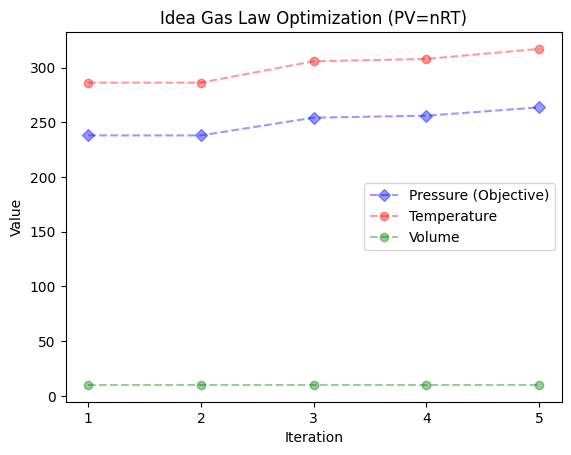

In [99]:
# Plot our results of the optimization
plt.plot(["1","2","3","4","5"], best_pressure, 'bD--', alpha=0.4, label="Pressure (Objective)")
plt.plot(["1","2","3","4","5"], best_temp, 'ro--', alpha=0.4, label="Temperature")
plt.plot(["1","2","3","4","5"], best_vol, 'go--', alpha=0.4, label="Volume")

plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Idea Gas Law Optimization (PV=nRT)")
plt.legend()
plt.show()
